# Instrument response modelling

Demonstration of how to build and use an instrument response to compare a model with data.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py

from instrument_response.toy_simulation import ToySimulation

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Forward model

In [19]:
# Define inputs

power_law_index = 1.0
min_energy = 1 # TeV
max_energy = 100 # TeV

simulation = ToySimulation(power_law_index, min_energy, max_energy)

In [20]:
# Run for large number of particles to generate response
N = int(1e5)
simulation.run(N)
simulation.save('output/demo.h5')

In [21]:
# Read in output
with h5py.File('output/demo.h5', 'r') as f:
    true_energy = f['true_energy'].value
    N_secondaries = f['number_of_secondaries'].value
    N_det_secondaries = f['number_of_detected_secondaries'].value
    detected_energy = f['detected_energy'].value
    initial_energy = f['initial_energy'].value

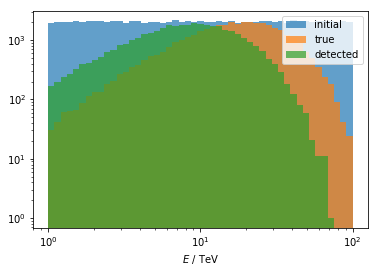

In [22]:
# Plot
bins = np.logspace(np.log(min_energy), np.log(max_energy), base=np.e)

fig, ax = plt.subplots();
ax.hist(initial_energy, bins=bins, alpha=0.7, label='initial')
ax.hist(true_energy, bins=bins, alpha=0.7, label='true');
ax.hist(detected_energy, bins=bins, alpha=0.7, label='detected');
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / TeV')
ax.legend();

## Response matrix

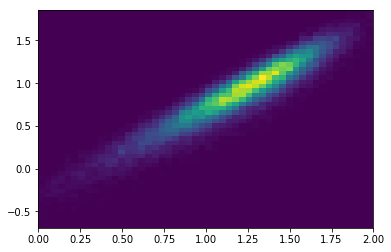

In [33]:
fig, ax = plt.subplots()
bins_det = np.logspace(np.log(min(detected_energy)), 
                       np.log(max(detected_energy)), base=np.e)
h, _, _, _ = ax.hist2d(np.log10(true_energy), np.log10(detected_energy), bins=[50,50]);